# Fetal Health Classification project

Fetal health is an ongoing medical concern, especially in the developing world.  Every year, there are thousands of preventable deaths of both children and mothers related to fetal health.  As part of efforts to study fetal health, researchers have developed a program to classify fetal cardiotocograms (CTGs) in a low-cost and automated manner (https://onlinelibrary.wiley.com/doi/10.1002/1520-6661(200009/10)9:5%3C311::AID-MFM12%3E3.0.CO;2-9).  As part of the study, 3 expert obstetricians classified 2126 CTG examples as Normal, Suspect, or Pathological.  Accompanying these examples are 21 predictive features from the CTGs extracted by the researchers' program, 8 continuous and 13 discrete.  

This data set makes up a 3-class classification problem.  In this project I will conduct an exploratory data analysis of this data set, then apply a gradient boosting classifier to the data set to learn the most important features.  I will analyze the results of the automated classifier and discuss the most important features of the data set.

# Import statements

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
import sklearn.ensemble as se
import xgboost as xgb
from xgboost import plot_tree
import lightgbm as lgbm
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
import sklearn.model_selection as sm
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import graphviz

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette='colorblind')

# Load data set

Display the first 25 entries and all of the fields, 22 in total including 1 target field, 'fetal_health'.  I replace the given fetal health labels such that 0 is 'Normal', 1 is 'Suspect, and 2 is 'Pathological' to make them more compatible with classification algorithms.  

In [2]:
df = pd.read_csv('archive/fetal_health.csv',sep=',',header=0)
#rename baseline value column to be in line with convention of other columns
df = df.rename(columns={'baseline value' : 'baseline_value'})
#rename fetal health outcomes
df.fetal_health = df.fetal_health.replace({1.0 : 0 , 2.0 : 1, 3.0 : 2}).sort_values()
print(df.columns)
df.head(25)

Index(['baseline_value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histogram_median', 'histogram_variance', 'histogram_tendency',
       'fetal_health'],
      dtype='object')


,baseline_value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.000,0.000,0.000,0.0,0.000,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,1.0
1,132.0,0.006,0.000,0.006,0.003,0.0,0.000,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,0.0
2,133.0,0.003,0.000,0.008,0.003,0.0,0.000,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,0.0
3,134.0,0.003,0.000,0.008,0.003,0.0,0.000,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,0.0
4,132.0,0.007,0.000,0.008,0.000,0.0,0.000,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,0.0
5,134.0,0.001,0.000,0.010,0.009,0.0,0.002,26.0,5.9,0.0,...,50.0,200.0,5.0,3.0,76.0,107.0,107.0,170.0,0.0,2.0
6,134.0,0.001,0.000,0.013,0.008,0.0,0.003,29.0,6.3,0.0,...,50.0,200.0,6.0,3.0,71.0,107.0,106.0,215.0,0.0,2.0
7,122.0,0.000,0.000,0.000,0.000,0.0,0.000,83.0,0.5,6.0,...,62.0,130.0,0.0,0.0,122.0,122.0,123.0,3.0,1.0,2.0
8,122.0,0.000,0.000,0.002,0.000,0.0,0.000,84.0,0.5,5.0,...,62.0,130.0,0.0,0.0,122.0,122.0,123.0,3.0,1.0,2.0
9,122.0,0.000,0.000,0.003,0.000,0.0,0.000,86.0,0.3,6.0,...,62.0,130.0,1.0,0.0,122.0,122.0,123.0,1.0,1.0,2.0


# Exploratory Data Analysis
Target column is fetal_health: 0 - Normal, 1 - Suspect, 2 - Pathological

First, I will plot a histogram of outcomes.  We can see that the majority of the data set consist of Normal cases.

0.0    1655
1.0     295
2.0     176
Name: fetal_health, dtype: int64

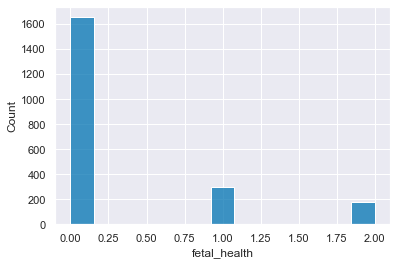

In [3]:
sns.histplot(data = df,x='fetal_health')
df.fetal_health.value_counts()

Now, I explore the relationship between fetal_health and predictor variables and check distributions for suspect values by visualizing the predictor variables by outcome.  I can see that many of the fields consist of integer values when we check the unique entries. It is impossible to tell if zeros are true zeros or missing values.  All of these values were detected with an automated method on raw CTG data, so I will not treat any of them as missing for now.  Due to the large difference in class sizes, I will normalize each metric by probability separately to get a better sense of the distribution of values for each class.

array([120., 132., 133., 134., 122., 151., 150., 131., 130., 129., 128.,
       124., 115., 114., 116., 158., 156., 148., 149., 146., 144., 142.,
       136., 141., 138., 140., 154., 145., 139., 125., 123., 159., 143.,
       119., 121., 127., 126., 118., 135., 137., 147., 157., 117., 152.,
       112., 106., 110., 160.])

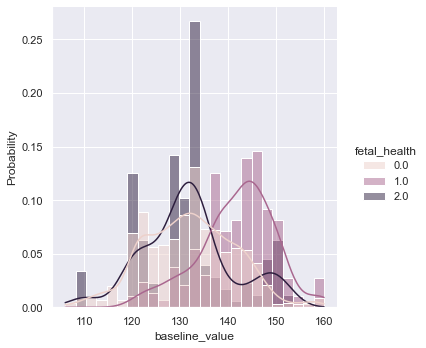

In [4]:
#baseline_value
#will normalize histograms separately due to differing sizes of category entries
sns.displot(data = df, x = 'baseline_value',hue='fetal_health',kde=True,
            stat='probability',common_norm=False,hue_order = ['Normal','Suspect','Pathological'])
df.baseline_value.unique()

fetal_health  accelerations
0.0           0.000            499
              0.003            152
              0.002            133
              0.001            112
              0.006            112
              0.004            110
              0.005            108
              0.008            103
              0.007             91
              0.009             60
              0.010             50
              0.011             36
              0.012             24
              0.013             22
              0.014             20
              0.015              9
              0.016              7
              0.017              4
              0.018              2
              0.019              1
1.0           0.000            249
              0.001             20
              0.002             20
              0.003              4
              0.004              1
              0.005              1
2.0           0.000            146
              0.001        

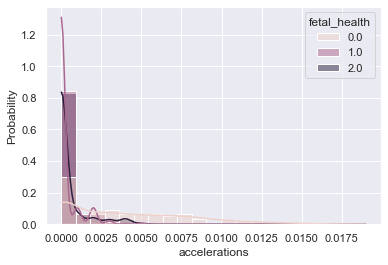

In [5]:
#accelerations
#Normal distribution has many more nonzero entries in this data set
sns.histplot(data = df, x = 'accelerations',hue='fetal_health',kde=True,
             stat='probability',common_norm=False,hue_order = ['Normal','Suspect','Pathological'])
df.groupby('fetal_health').accelerations.value_counts()

0.000    1311
0.001     164
0.002     112
0.003      88
0.004      49
         ... 
0.079       1
0.109       1
0.103       1
0.031       1
0.099       1
Name: fetal_movement, Length: 102, dtype: int64

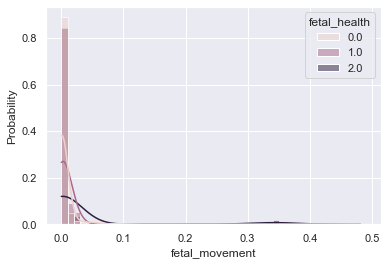

In [6]:
#fetal_movement
#Most of this category is zero, categories are similar
sns.histplot(data = df, x = 'fetal_movement',hue='fetal_health',kde=True,binwidth=0.01,
             stat='probability',common_norm=False,hue_order = ['Normal','Suspect','Pathological'])
df.fetal_movement.value_counts()

0.000    332
0.005    290
0.004    244
0.006    231
0.007    216
0.003    212
0.008    160
0.002    160
0.001    118
0.009     82
0.010     49
0.011     16
0.012     11
0.013      2
0.014      2
0.015      1
Name: uterine_contractions, dtype: int64

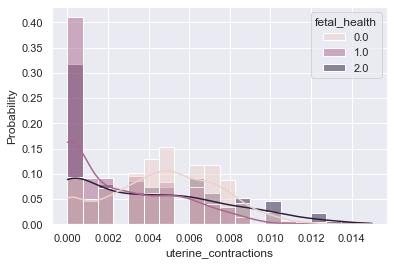

In [7]:
#uterine_contractions
#Normal fetuses show more uterine contractions
sns.histplot(data = df, x = 'uterine_contractions',hue='fetal_health',kde=True,
             stat='probability',common_norm=False,hue_order = ['Normal','Suspect','Pathological'])
df.uterine_contractions.value_counts()

0.000    1231
0.001     163
0.003     118
0.002     115
0.004     114
0.005     107
0.006      74
0.008      55
0.007      54
0.009      37
0.010      15
0.011      13
0.012      12
0.013       8
0.014       7
0.015       3
Name: light_decelerations, dtype: int64

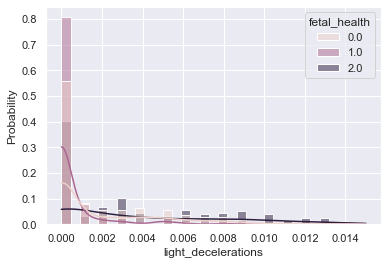

In [8]:
#light_decelerations
#suspect fetuses show least LDs
sns.histplot(data = df, x = 'light_decelerations',hue='fetal_health',kde=True,
             stat='probability',common_norm=False,hue_order = ['Normal','Suspect','Pathological'])
df.light_decelerations.value_counts()

fetal_health  abnormal_short_term_variability
0.0           58.0                               55
              22.0                               48
              51.0                               48
              25.0                               45
              37.0                               40
                                                 ..
2.0           58.0                                1
              69.0                                1
              72.0                                1
              76.0                                1
              87.0                                1
Name: abnormal_short_term_variability, Length: 164, dtype: int64

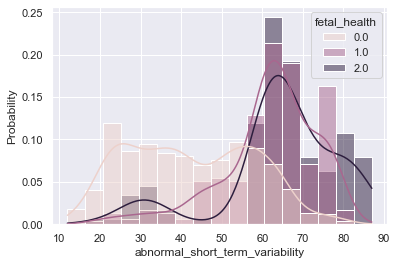

In [9]:
#abnormal_short_term_variability
#Normal distribution has many more nonzero entries in this data set
sns.histplot(data = df, x = 'abnormal_short_term_variability',hue='fetal_health',kde=True,
             stat='probability',common_norm=False,hue_order = ['Normal','Suspect','Pathological'])
df.groupby('fetal_health').abnormal_short_term_variability.value_counts()

fetal_health  prolongued_decelerations
0.0           0.000                       1586
              0.001                         54
              0.002                         14
              0.003                          1
1.0           0.000                        280
              0.002                          7
              0.001                          5
              0.003                          3
2.0           0.000                         82
              0.002                         51
              0.003                         20
              0.001                         11
              0.004                          9
              0.005                          3
Name: prolongued_decelerations, dtype: int64

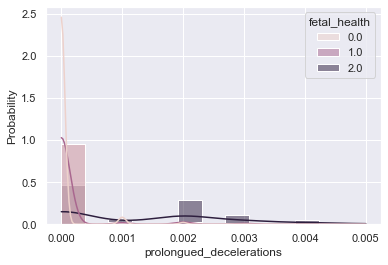

In [10]:
#prolongued_decelerations
#PDs most associated with pathological cases
sns.histplot(data = df, x = 'prolongued_decelerations',hue='fetal_health',kde=True,
             stat='probability',common_norm=False,hue_order = ['Normal','Suspect','Pathological'])
df.groupby('fetal_health').prolongued_decelerations.value_counts()

fetal_health  mean_value_of_long_term_variability
0.0           0.0                                    64
              6.7                                    21
              7.1                                    21
              5.2                                    18
              6.3                                    18
                                                     ..
2.0           12.3                                    1
              14.2                                    1
              15.6                                    1
              19.4                                    1
              21.5                                    1
Name: mean_value_of_long_term_variability, Length: 424, dtype: int64

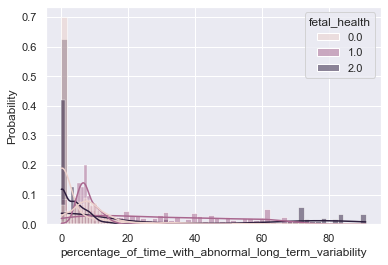

In [11]:
#percentage_of_time_with_abnormal_long_term_variability
#Normal distribution has many more nonzero entries in this data set
sns.histplot(data = df, x = 'percentage_of_time_with_abnormal_long_term_variability',hue='fetal_health',kde=True,
             stat='probability',common_norm=False,hue_order = ['Normal','Suspect','Pathological'])
df.groupby('fetal_health').percentage_of_time_with_abnormal_long_term_variability.value_counts()

#mean_value_of_long_term_variability
#Normal distribution has many more nonzero entries in this data set
sns.histplot(data = df, x = 'mean_value_of_long_term_variability',hue='fetal_health',kde=True,
             stat='probability',common_norm=False,hue_order = ['Normal','Suspect','Pathological'])
df.groupby('fetal_health').mean_value_of_long_term_variability.value_counts()

fetal_health  histogram_median
0.0           134.0               60
              137.0               57
              147.0               53
              149.0               53
              141.0               52
                                  ..
2.0           134.0                1
              141.0                1
              147.0                1
              152.0                1
              155.0                1
Name: histogram_median, Length: 188, dtype: int64

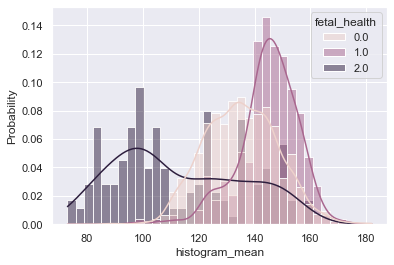

In [12]:
#histogram_mean
#Normal distribution has many more nonzero entries in this data set
sns.histplot(data = df, x = 'histogram_mean',hue='fetal_health',kde=True,
             stat='probability',common_norm=False,hue_order = ['Normal','Suspect','Pathological'])
df.groupby('fetal_health').histogram_median.value_counts()

# Split data into training and validation sets

I see that there is no additional data cleaning that is necessary, so now I split the data into training and validation sets.  I take 30% of the data, decided randomly, and use it as a validation set.  Additionally, I separate the target field, fetal_health from the rest of the fields.  

In [13]:
df.fetal_health = df.fetal_health.replace({'Normal': 0 , 'Suspect' : 1, 'Pathological' : 2})
X_train,X_valid,y_train,y_valid = sm.train_test_split(df.iloc[:,:-1],df.iloc[:,-1],test_size=0.3,random_state=12356)
print(X_train.shape,X_valid.shape,y_train.shape,y_valid.shape)
y_train.head()

(1488, 21) (638, 21) (1488,) (638,)


1117    0.0
518     0.0
1677    0.0
1927    2.0
938     0.0
Name: fetal_health, dtype: float64

# Set up pipeline and parameter grid for XGBoost
Here, I set up a data processing pipeline that scales each field in one of two ways.  The MinMaxScaler transforms the field such that all values exist in the range of 0 to 1.  I use this scaling so that zero values are preserved in many of the sparse fields that I observed in the exploratory data analysis, such as light_decelerations.  The StandardScaler transforms the field such that it has zero mean and standard deviation of 1.  This is more useful for non-sparse fields, such as baseline value.  The appropriate scaler for each field was chosen manually.  The pipeline feature in sklearn then pre-processes any data set that I wish to feed to a classifier automatically.  

The classifier that I use here is the Extreme Gradient Boosting classifier (xgboost).  I also define a dictionary of possible hyperparameters to randomly search to select hyperparameters that give the best performance.  

The metric that I will use to evaluate the classifier is the ROC-AUC score (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html), which takes into account precision and recall of all 3 classes in this problem.

In [14]:
print(df.columns)
std_features = ['baseline_value','abnormal_short_term_variability','mean_value_of_short_term_variability','histogram_width',
               'histogram_min','histogram_max','histogram_mode','histogram_mean','histogram_median','histogram_tendency',
               'mean_value_of_long_term_variability']
minmax_features = ['accelerations','fetal_movement','uterine_contractions',
                   'light_decelerations','severe_decelerations','prolongued_decelerations',
                  'percentage_of_time_with_abnormal_long_term_variability',
                  'histogram_number_of_peaks','histogram_number_of_zeroes','histogram_variance']
minmax_pipeline = Pipeline(steps=[('impute',SimpleImputer(missing_values = np.nan, strategy='mean')),('scale',MinMaxScaler())])
std_pipeline = Pipeline(steps=[('impute',SimpleImputer(missing_values = np.nan, strategy='mean')),('scale',StandardScaler())])
minmax_pipeline.fit_transform(X_train[minmax_features])
std_pipeline.fit_transform(X_train[std_features])
full_processor = ColumnTransformer(transformers=[
    ('minmax', minmax_pipeline, minmax_features),
    ('std', std_pipeline, std_features)
])
mod = xgb.XGBClassifier()
pipeline = Pipeline(steps=[('preprocess',full_processor),('model',mod)])
param_grid = {'model__booster' : ['gbtree'], 
              'model__n_estimators' : [10,50,100,500,1000,5000], 
              'model__learning_rate' : [0.001,0.005,0.01,0.05,0.1,0.5,1],
              'model__max_depth' : list(range(1,11)),
              'model__colsample_bytree' : [0.001,0.005,0.01,0.05,0.1,0.5,1],
              'model__objective' : ['multi:softmax','multi:softprob'],
              'model__num_class' : [3],
              'model__use_label_encoder' : [False],
              'model__eval_metric' : ['mlogloss','merror']}
clf = sm.RandomizedSearchCV(pipeline,param_grid,n_iter=5)
clf.scorer_ = roc_auc_score

Index(['baseline_value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histogram_median', 'histogram_variance', 'histogram_tendency',
       'fetal_health'],
      dtype='object')


We can see that this model achieves an accuracy of about 95%.

In [15]:
clf.fit(X_train,y_train)
clf.best_score_

0.94220052877771

In [16]:
clf.cv_results_
clf.best_params_

{'model__use_label_encoder': False,
 'model__objective': 'multi:softmax',
 'model__num_class': 3,
 'model__n_estimators': 50,
 'model__max_depth': 6,
 'model__learning_rate': 0.1,
 'model__eval_metric': 'merror',
 'model__colsample_bytree': 1,
 'model__booster': 'gbtree'}

In [17]:
optimal_params = clf.best_params_
print(optimal_params)
print('The best model has ROC-AUC score of: %0.4f' % clf.best_score_)

{'model__use_label_encoder': False, 'model__objective': 'multi:softmax', 'model__num_class': 3, 'model__n_estimators': 50, 'model__max_depth': 6, 'model__learning_rate': 0.1, 'model__eval_metric': 'merror', 'model__colsample_bytree': 1, 'model__booster': 'gbtree'}
The best model has ROC-AUC score of: 0.9422


# Take optimal parameters and use them

We can see that the classifier has the most trouble predicting Suspect diagnoses

[10:54:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\bighi\anaconda3\lib\site-packages\xgboost\core.py:499: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


The confusion matrix for the best model is:
 [[490  11   4]
 [ 17  69   0]
 [  2   0  45]]
Column order: Normal, Suspect, Pathological
Precision:
 [0.96267191 0.8625     0.91836735]
Recall:
 [0.97029703 0.80232558 0.95744681]
F-Score:
 [0.96646943 0.8313253  0.9375    ]
Support:
 [505  86  47]





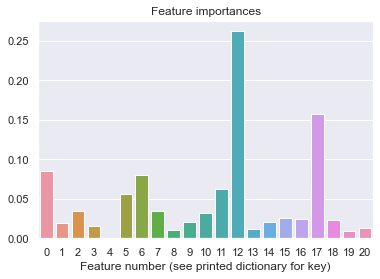

{0: 'baseline_value', 1: 'accelerations', 2: 'fetal_movement', 3: 'uterine_contractions', 4: 'light_decelerations', 5: 'severe_decelerations', 6: 'prolongued_decelerations', 7: 'abnormal_short_term_variability', 8: 'mean_value_of_short_term_variability', 9: 'percentage_of_time_with_abnormal_long_term_variability', 10: 'mean_value_of_long_term_variability', 11: 'histogram_width', 12: 'histogram_min', 13: 'histogram_max', 14: 'histogram_number_of_peaks', 15: 'histogram_number_of_zeroes', 16: 'histogram_mode', 17: 'histogram_mean', 18: 'histogram_median', 19: 'histogram_variance', 20: 'histogram_tendency'}


In [18]:
mod = xgb.XGBClassifier(optimal_params,use_label_encoder=False)
clf_opt = Pipeline(steps=[('preprocess',full_processor),('model',mod)])
clf_opt.fit(X_train,y_train)
feat_imp = clf_opt.named_steps['model'].feature_importances_
print('The confusion matrix for the best model is:\n', confusion_matrix(y_valid,clf_opt.predict(X_valid)))
prfs = precision_recall_fscore_support(y_valid,clf_opt.predict(X_valid))
print('Column order: Normal, Suspect, Pathological')
print('Precision:\n', prfs[0])
print('Recall:\n', prfs[1])
print('F-Score:\n', prfs[2])
print('Support:\n', prfs[3])
print('\n\n')
g = sns.barplot(x=list(range(len(feat_imp))),y=feat_imp)
g.set_title('Feature importances')
g.set_xlabel('Feature number (see printed dictionary for key)')
plt.show()
print(dict(zip(list(range(len(feat_imp))),X_train.columns)))


# Re-examine features of high importance

The four most important features, in order of descending importance, are 'histogram_min', 'histogram_mean', 'baseline_value', and 'prolongued_decelerations'.  

Plotting a 2D histogram with the two features of highest importance, we see that Pathological cases are characterized by low histogram_mean and a spread of histogram_min, Suspect cases have low histogram_min and high histogram_mean, while Normal cases have a spread of histogram_min and somewhat high histogram_mean.

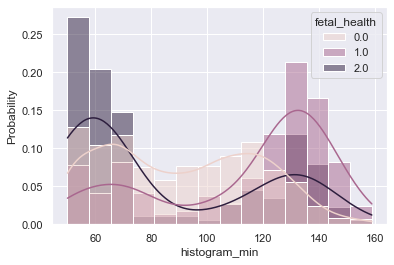

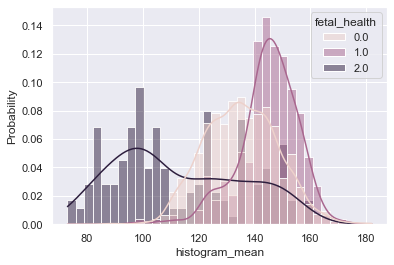

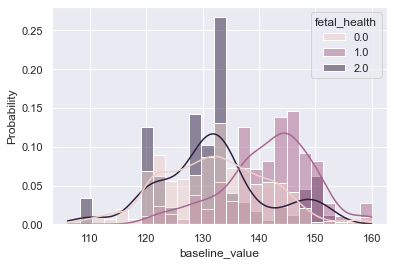

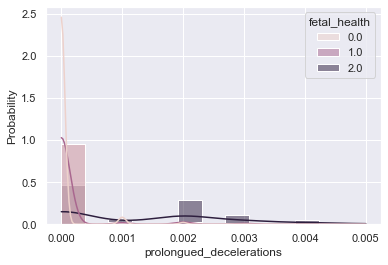

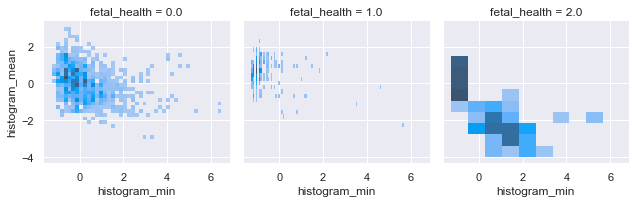

In [19]:
df_trans = pd.DataFrame(full_processor.transform(df),columns=df.columns[:-1])
df_trans = pd.concat((df_trans,df['fetal_health']),axis=1)

sns.histplot(df,x=df['histogram_min'],hue='fetal_health',kde=True,stat='probability',common_norm=False)
plt.show()
sns.histplot(df,x=df['histogram_mean'],hue='fetal_health',kde=True,stat='probability',common_norm=False)
plt.show()
sns.histplot(df,x=df['baseline_value'],hue='fetal_health',kde=True,stat='probability',common_norm=False)
plt.show()
sns.histplot(df,x=df['prolongued_decelerations'],hue='fetal_health',kde=True,stat='probability',common_norm=False)
plt.show()

g = sns.FacetGrid(df_trans,col = 'fetal_health')
g.map(sns.histplot,'histogram_min','histogram_mean')
plt.show()
#sns.histplot(data = df, x = 'mean_value_of_short_term_variability',y = 'histogram_mean', hue='fetal_health',kde=True,
#             stat='probability',common_norm=False,hue_order = ['Normal','Suspect','Pathological'])

# Conclusions

Extreme Gradient Boosting works very well to classify this Fetal Health data set, with a ROC-AUC score of over 0.94.  Examination of the F-score for each prediction class reveals that it struggles most to classify Suspect cases, with an F-Score of about 0.80.  It makes sense that Suspect cases would be hardest to classify, since they have characteristic of both Normal and Pathological categories.  That being said, an F-score of 0.80 is still quite successful.  These findings suggest that the task of diagnosing fetal health based on CTGs could be largely automated.  

# Now attempt the same classification problem with SVM

In [20]:
from sklearn.svm import SVC
print(df.columns)
std_features = ['baseline_value','abnormal_short_term_variability','mean_value_of_short_term_variability','histogram_width',
               'histogram_min','histogram_max','histogram_mode','histogram_mean','histogram_median','histogram_tendency',
               'mean_value_of_long_term_variability']
minmax_features = ['accelerations','fetal_movement','uterine_contractions',
                   'light_decelerations','severe_decelerations','prolongued_decelerations',
                  'percentage_of_time_with_abnormal_long_term_variability',
                  'histogram_number_of_peaks','histogram_number_of_zeroes','histogram_variance']
minmax_pipeline = Pipeline(steps=[('impute',SimpleImputer(missing_values = np.nan, strategy='mean')),('scale',MinMaxScaler())])
std_pipeline = Pipeline(steps=[('impute',SimpleImputer(missing_values = np.nan, strategy='mean')),('scale',StandardScaler())])
minmax_pipeline.fit_transform(X_train[minmax_features])
std_pipeline.fit_transform(X_train[std_features])
full_processor = ColumnTransformer(transformers=[
    ('minmax', minmax_pipeline, minmax_features),
    ('std', std_pipeline, std_features)
])
mod = SVC()
pipeline = Pipeline(steps=[('preprocess',full_processor),('model',mod)])
param_grid = {'model__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'], 
              'model__degree' : [1,2,3,4,5], 
              'model__C' : [0.001,0.01,0.1,1.0,5.0,10.0,100.0],
              'model__gamma' : ['scale', 'auto'],
              'model__shrinking' : [True,False],
              'model__coef0' : [-1.0,0.0,1.0],
              'model__decision_function_shape' : ['ovo','ovr']}
clf = sm.RandomizedSearchCV(pipeline,param_grid,n_iter=50)
clf.scorer_ = roc_auc_score

Index(['baseline_value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histogram_median', 'histogram_variance', 'histogram_tendency',
       'fetal_health'],
      dtype='object')


In [21]:
clf.fit(X_train,y_train)
clf.best_score_

0.9200167220301448

In [22]:
optimal_params = clf.best_params_
print(optimal_params)
print('The best model has ROC-AUC score of: %0.4f' % clf.best_score_)

print('The confusion matrix for the best model is:\n', confusion_matrix(y_valid,clf.predict(X_valid)))
prfs = precision_recall_fscore_support(y_valid,clf.predict(X_valid))
print('Column order: Normal, Suspect, Pathological')
print('Precision:\n', prfs[0])
print('Recall:\n', prfs[1])
print('F-Score:\n', prfs[2])
print('Support:\n', prfs[3])
print('\n\n')

{'model__shrinking': False, 'model__kernel': 'rbf', 'model__gamma': 'scale', 'model__degree': 1, 'model__decision_function_shape': 'ovo', 'model__coef0': -1.0, 'model__C': 100.0}
The best model has ROC-AUC score of: 0.9200
The confusion matrix for the best model is:
 [[487  13   5]
 [ 16  68   2]
 [  4   4  39]]
Column order: Normal, Suspect, Pathological
Precision:
 [0.96055227 0.8        0.84782609]
Recall:
 [0.96435644 0.79069767 0.82978723]
F-Score:
 [0.96245059 0.79532164 0.83870968]
Support:
 [505  86  47]





# SVM does well, but not quite as well as GBT

# Let's try with K-means

In [23]:
from sklearn.cluster import KMeans
print(df.columns)
std_features = ['baseline_value','abnormal_short_term_variability','mean_value_of_short_term_variability','histogram_width',
               'histogram_min','histogram_max','histogram_mode','histogram_mean','histogram_median','histogram_tendency',
               'mean_value_of_long_term_variability']
minmax_features = ['accelerations','fetal_movement','uterine_contractions',
                   'light_decelerations','severe_decelerations','prolongued_decelerations',
                  'percentage_of_time_with_abnormal_long_term_variability',
                  'histogram_number_of_peaks','histogram_number_of_zeroes','histogram_variance']
minmax_pipeline = Pipeline(steps=[('impute',SimpleImputer(missing_values = np.nan, strategy='mean')),('scale',MinMaxScaler())])
std_pipeline = Pipeline(steps=[('impute',SimpleImputer(missing_values = np.nan, strategy='mean')),('scale',StandardScaler())])
minmax_pipeline.fit_transform(X_train[minmax_features])
std_pipeline.fit_transform(X_train[std_features])
full_processor = ColumnTransformer(transformers=[
    ('minmax', minmax_pipeline, minmax_features),
    ('std', std_pipeline, std_features)
])
n_clusters = df.fetal_health.nunique()
mod = KMeans(n_clusters = 3,n_init = 100, max_iter = 1000, algorithm = 'auto')
pipeline = Pipeline(steps=[('preprocess',full_processor),('model',mod)])
#param_grid = {'model__n_clusters' : [3], 
#              'model__n_init' : [10], 
#              'model__max_iter' : [100,300,500,1000],
#              'model__algorithm' : ['full','auto','elkan']}
#clf = sm.RandomizedSearchCV(pipeline,param_grid,n_iter=50)
#clf.scorer_ = roc_auc_score

Index(['baseline_value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histogram_median', 'histogram_variance', 'histogram_tendency',
       'fetal_health'],
      dtype='object')


In [24]:
pipeline.fit(X_train)
y_labels_train = pipeline.named_steps['model'].labels_
print(y_labels_train.shape)
y_labels_valid = pipeline.predict(X_valid)
print(classification_report(y_train,y_labels_train))


(1488,)
              precision    recall  f1-score   support

         0.0       0.63      0.29      0.40      1150
         1.0       0.03      0.07      0.04       209
         2.0       0.01      0.04      0.02       129

    accuracy                           0.24      1488
   macro avg       0.22      0.13      0.15      1488
weighted avg       0.49      0.24      0.32      1488



# K-means does not work on this data set at all

Let's try using it as a feature for SVM prediction

In [25]:
X_train['k_clust'] = y_labels_train
X_valid['k_clust'] = y_labels_valid

In [26]:
from sklearn.svm import SVC
print(X_train.columns)
std_features = ['baseline_value','abnormal_short_term_variability','mean_value_of_short_term_variability','histogram_width',
               'histogram_min','histogram_max','histogram_mode','histogram_mean','histogram_median','histogram_tendency',
               'mean_value_of_long_term_variability']
minmax_features = ['accelerations','fetal_movement','uterine_contractions',
                   'light_decelerations','severe_decelerations','prolongued_decelerations',
                  'percentage_of_time_with_abnormal_long_term_variability',
                  'histogram_number_of_peaks','histogram_number_of_zeroes','histogram_variance']
minmax_pipeline = Pipeline(steps=[('impute',SimpleImputer(missing_values = np.nan, strategy='mean')),('scale',MinMaxScaler())])
std_pipeline = Pipeline(steps=[('impute',SimpleImputer(missing_values = np.nan, strategy='mean')),('scale',StandardScaler())])
minmax_pipeline.fit_transform(X_train[minmax_features])
std_pipeline.fit_transform(X_train[std_features])
full_processor = ColumnTransformer(transformers=[
    ('minmax', minmax_pipeline, minmax_features),
    ('std', std_pipeline, std_features)
])
mod = SVC()
pipeline = Pipeline(steps=[('preprocess',full_processor),('model',mod)])
param_grid = {'model__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'], 
              'model__degree' : [1,2,3,4,5], 
              'model__C' : [0.001,0.01,0.1,1.0,5.0,10.0,100.0],
              'model__gamma' : ['scale', 'auto'],
              'model__shrinking' : [True,False],
              'model__coef0' : [-1.0,0.0,1.0],
              'model__decision_function_shape' : ['ovo','ovr']}
clf = sm.RandomizedSearchCV(pipeline,param_grid,n_iter=50)
clf.scorer_ = roc_auc_score
clf.fit(X_train,y_train)
clf.best_score_
optimal_params = clf.best_params_
print(optimal_params)
print('The best model has ROC-AUC score of: %0.4f' % clf.best_score_)

print('The confusion matrix for the best model is:\n', confusion_matrix(y_valid,clf.predict(X_valid)))
prfs = precision_recall_fscore_support(y_valid,clf.predict(X_valid))
print('Column order: Normal, Suspect, Pathological')
print('Precision:\n', prfs[0])
print('Recall:\n', prfs[1])
print('F-Score:\n', prfs[2])
print('Support:\n', prfs[3])
print('\n\n')

Index(['baseline_value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histogram_median', 'histogram_variance', 'histogram_tendency',
       'k_clust'],
      dtype='object')
{'model__shrinking': False, 'model__kernel': 'rbf', 'model__gamma': 'scale', 'model__degree': 3, 'model__decision_function_shape': 'ovo', 'model__coef0': -1.0, 'model__C': 100.0}
The best model has ROC-AUC score of: 0.9200
The confusion matrix for the best model is:
 [[487  13   5]
 [ 16  68   2]
 [  4   4  39]]
Column order: Normal, Suspect, Pathological
Pr

# K-means as a feature does not help the performance of SVM at all!